In [1]:
import photutils
import numpy as np
from astropy.io import fits
from photutils.background import Background2D, MedianBackground, SExtractorBackground
from astropy.convolution import convolve
from photutils.segmentation import make_2dgaussian_kernel
from photutils.segmentation import detect_sources
import matplotlib.pyplot as plt
from dawis import sample_noise, inpaint_with_gaussian_noise
from astropy.visualization import SqrtStretch, ZScaleInterval, LinearStretch
from astropy.visualization.mpl_normalize import ImageNormalize

In [3]:
hdu = fits.open('/home/aellien/Euclid_LSB_DR1/data/EUC_EDF_N/EUC_VIS_LSB_ObsID_2690_scaled.fits')
orim = hdu[1].data
data = np.copy(orim)
data[data == 0.] = np.nan

In [4]:
#bkg_estimator = MedianBackground()
bkg_estimator = SExtractorBackground()
bkg = Background2D(data, (50, 50), filter_size=(31, 31), bkg_estimator=bkg_estimator)
data -= bkg.background  # subtract the background

In [5]:
threshold = 1.1 * bkg.background_rms
kernel = make_2dgaussian_kernel(10.0, size = 11)  # FWHM = 3.0
convolved_data = convolve(data, kernel)
segment_map = detect_sources(convolved_data, threshold, npixels = 5)

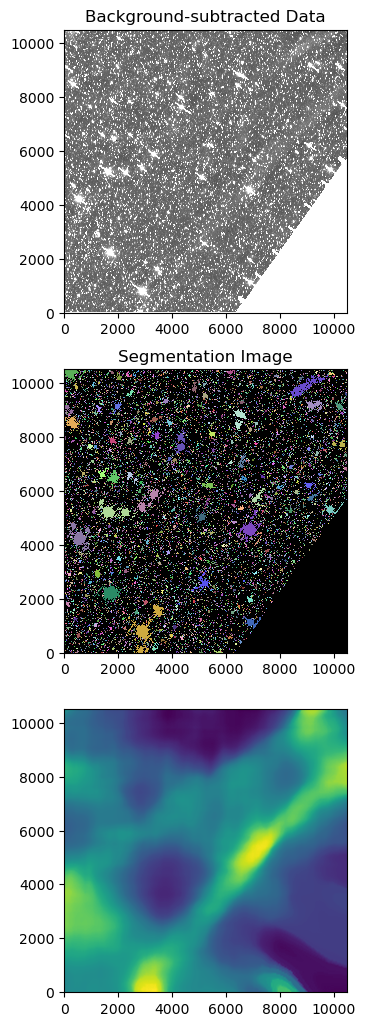

In [6]:
norm = ImageNormalize(data, interval = ZScaleInterval(), stretch = LinearStretch())
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12.5))
ax1.imshow(data, origin='lower', cmap='Greys_r', norm=norm)
ax1.set_title('Background-subtracted Data')
ax2.imshow(segment_map, origin='lower', cmap=segment_map.cmap,
           interpolation='nearest')
ax2.set_title('Segmentation Image')
ax3.imshow(bkg.background, origin = 'lower')
plt.show()

In [ ]:
mask = np.copy(segment_map.data)
mask[mask > 0] = 1.
orim[mask > 0] = np.nan
orim[orim == 0.] = np.nan

noise_pixels, valmax = sample_noise(orim, n_sigmas = 3, bins = 200)
mean, sigma = np.mean(noise_pixels), np.std(noise_pixels)
iptim = inpaint_with_gaussian_noise(orim, mean = mean, sigma = sigma, iptd_sigma = 5)

hduo = fits.PrimaryHDU(orim, header = hdu[1].header)
hduo.writeto('/home/aellien/Euclid_LSB_DR1/tests/EUC_VIS_LSB_ObsID_2690_scaled_masked.fits', overwrite = True)